In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import he_normal

In [2]:
def to_one_hot(labels):
    """
    Encode labels with categorical encoding
    :param labels: labels encoded with label encoder
    :return: one-hot encoded results
    """
    results = np.zeros((len(labels), len(set(labels))))
    for i, label in enumerate(labels):
        results[i,label] = 1.0
    return results

In [3]:
def initDataset(X, y, test_size=0.3):
    """
    Normalize, split and encode dataset
    :param X: feature values, array-like of shape (n_samples, n_features)
    :param y: labels for each sample
    :param test_size: float from 0 to 1 (Default: 0.3)
    :return: tuple of (X_train, X_test, y_train, y_test, y_train_encoded, y_test_encoded)
    """
    # Normalize the dataset features by Z-Score
    X_scaled = StandardScaler().fit_transform(X)
    # Split the dataset with stratified method
    # Default train_size:test_size = 7:3
    X_train, X_test, y_train, y_test = train_test_split(X_scaled,
                                                        y,
                                                        test_size=test_size,
                                                        random_state=986,
                                                        shuffle=True,
                                                        stratify=y)
    # Encode y with categorical encoding
    y_train_encoded = to_one_hot(y_train)
    y_test_encoded = to_one_hot(y_test)
    return X_train, X_test, y_train, y_test, y_train_encoded, y_test_encoded

In [4]:
def createBPNN(L, n_inputs, n_hidden, n_L, lr=0.001):
    """
    Initialize and compile a BPNN Model
    :param L: #Layers (the number of layers)
    :param n_inputs: #Features (the number of features for a sample)
    :param n_hidden: the number of units for each hidden layer
    :param n_L: the number of units for output layer
    :param lr: learning rate for the optimizer (Default: 0.001)
    :return: compiled BPNN Model
    """
    # BP-Neural Network Model Definition
    # Sequential groups a linear stack of layers
    BPNN = Sequential(name='BPNN')
    # Add an input layer with shape of (n_inputs,) to BPNN Model, as well as
    # the input layer and the first layer with n_inputs units,
    # L-3 hidden layers from 2 to L-1 with n_hidden units each layer,
    # and an output layer with n_L units.
    Dense_Attr = {
    'use_bias': True,
    'kernel_initializer': he_normal(seed=917),
    'bias_initializer': 'zeros',
    'kernel_regularizer': l1_l2(l1=0.01, l2=0.01)
    }
    BPNN.add(Dense(units=n_inputs, input_shape=(n_inputs,), 
                   activation='tanh',
                   **Dense_Attr, 
                   name='Layer1'))
    for i in range(2, L):
        BPNN.add(Dense(units=n_hidden, 
                       activation='tanh',
                       **Dense_Attr, 
                       name='Layer'+str(i)))
    BPNN.add(Dense(units=n_L, 
                   activation='softmax', 
                   **Dense_Attr, 
                   name='Output_layer'))
    BPNN.compile(optimizer=Adam(lr=lr, beta_1=0.9, beta_2=0.999), 
                 loss='categorical_crossentropy')
    return BPNN

In [5]:
def fitModel(BPNN, batch_size, epochs, **dataset):
    """
    Fit BPNN model, visualize training history, and predict the test samples
    :param BPNN: model class
    :param batch_size: size of a batch
    :param epochs: number of training iterations
    :param dataset: include X_train, X_test, y_train_encoded, and y_test_encoded
    :return: tuple of (the probability that test samples belong to each class, the result of classification)
    """
    # Fit BPNN Model
    history = BPNN.fit(x=dataset['X_train'],
                       y=dataset['y_train_encoded'],
                       batch_size=batch_size,
                       epochs=epochs,
                       validation_data=(dataset['X_test'], dataset['y_test_encoded']),
                       verbose=0,
                       shuffle=True)
    # Visualize training history
    plt.plot(history.history['loss'], color='g', label='Train')
    plt.plot(history.history['val_loss'], color='r', label='Test')
    plt.title('Model loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.savefig('Model loss', dpi=400, bbox_inches='tight')
    plt.show()
    # Output the probability that test samples belong to each class
    # Array of float, shape of (n_samples, n_classes)
    y_pred_p = BPNN.predict(dataset['X_test'])
    # Output the result of classification
    y_pred = [np.argmax(y_pred_p[i]) for i in range(y_pred_p.shape[0])]
    return y_pred_p, y_pred

In [6]:
def CalcF1Scores(y_true, y_pred, labels, target_names):
    """
    Evaluete model by precision values, recall values, and F1-Scores. Print all of them
    :param y_true: ground truth (correct) target values
    :param y_pred: estimated targets as returned by a classifier
    :param labels: list of label indices to include in the report
    :param target_names: display names matching the labels (same order)
    :return: None
    """
    print(classification_report(y_true, y_pred, labels=labels, target_names=target_names))

In [7]:
def DrawROCGraph(y_true, y_pred_p, colors, label_names):
    """
    Draw ROC-AUC graph
    :param y_true: true labels
    :param y_pred_p: the probability that test samples belong to each class
    :param colors: the colors of ROC curves for each class
    :param label_names: names of labels (the same order as colors)
    :return: None
    """
    lw = 2
    plt.plot([0, 1], [0, 1], color='black', lw=lw, linestyle='--')
    for i in range(y_pred_p.shape[1]):
        scores = y_pred_p[:,i]
        fpr, tpr, thresholds = roc_curve(y_true, scores, pos_label=i)
        plt.plot(fpr,
                 tpr,
                 color=colors[i],
                 lw=lw,
                 label='ROC curve %s (area = %.3f)' % (label_names[i], roc_auc_score(y_true==i, scores)))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('ROC', dpi=400, bbox_inches='tight')
    plt.show()

In [8]:
def saveModel(model):
    """
    Save model's weights and biases for each layer, and print its brief description
    :param model: Model in Keras
    :return: None
    """
    print(model.summary())
    with pd.ExcelWriter('ModelDescription.xlsx') as writer:
        attr = {'header': False, 'index': False}
        for layer in model.layers:
            layer_name = layer.name
            weight = layer.get_weights()[0]
            bias = layer.get_weights()[1]
            # Print
            print('w[%s]: ' % layer_name)
            print(weight)
            print('b[%s]: ' % layer_name)
            print(bias)
            # Save as Excel
            pd.DataFrame(weight).to_excel(writer, 'w_%s'%layer_name, **attr)
            pd.DataFrame(bias).to_excel(writer, 'b_%s'%layer_name, **attr)
    # Save model as HDF5
    model.save('model.h5')

In [9]:
df = pd.read_excel('股票因子.xlsx')
df.head(3)

,股票代码,股票简称,FAC1,FAC2,FAC3,FAC4,FAC5,FAC6,FAC7,FAC8,FAC9,财务状况
0,000606.SZ,ST顺利,-0.855124,1.291562,0.612782,0.311189,-1.015941,0.504615,2.195079,1.594154,1.086768,0
1,000673.SZ,*ST当代,-1.365196,-0.090322,0.844945,-0.085126,-1.650376,0.697448,-1.144989,-0.924063,0.332632,0
2,000681.SZ,视觉中国,-0.020451,-0.305338,0.172405,-0.414931,-1.658652,-1.150607,-0.933424,0.358798,-0.003965,1


In [10]:
df['财务状况'].value_counts()

1    40
0    18
Name: 财务状况, dtype: int64

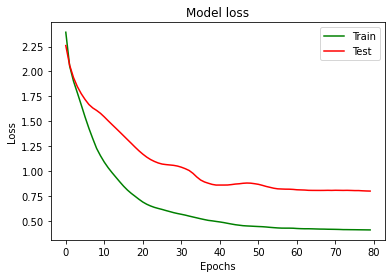

              precision    recall  f1-score   support

      *ST/ST       1.00      0.67      0.80         6
      Normal       0.86      1.00      0.92        12

    accuracy                           0.89        18
   macro avg       0.93      0.83      0.86        18
weighted avg       0.90      0.89      0.88        18



In [11]:
X_train, X_test, y_train, y_test, y_train_encoded, y_test_encoded = initDataset(df.iloc[:,2:-1].values,
                                                                                df.iloc[:,-1].values,
                                                                                test_size=0.3)
BPNN = createBPNN(L=5, n_inputs=9, n_hidden=7, n_L=2, lr=0.04)
y_pred_p, y_pred = fitModel(BPNN,
                            batch_size=X_train.shape[0],
                            epochs=80,
                            X_train = X_train,
                            X_test = X_test,
                            y_train_encoded = y_train_encoded,
                            y_test_encoded = y_test_encoded)
CalcF1Scores(y_true=y_test, y_pred=y_pred, labels=[0,1], target_names=['*ST/ST','Normal'])

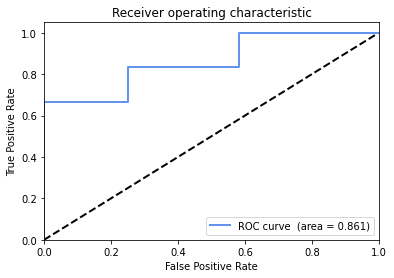

In [12]:
DrawROCGraph(y_true=y_test,
             y_pred_p=y_pred_p[:,0:1],
             colors=['cornflowerblue'],
             label_names=[''])

In [13]:
saveModel(BPNN)

Model: "BPNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Dense)               (None, 9)                 90        
_________________________________________________________________
Layer2 (Dense)               (None, 7)                 70        
_________________________________________________________________
Layer3 (Dense)               (None, 7)                 56        
_________________________________________________________________
Layer4 (Dense)               (None, 7)                 56        
_________________________________________________________________
Output_layer (Dense)         (None, 2)                 16        
Total params: 288
Trainable params: 288
Non-trainable params: 0
_________________________________________________________________
None
w[Layer1]: 
[[ 2.32883636e-03 -3.26347654e-03  7.02115381e-03  1.88290887e-02
   3.65905046e-01  1.90060586e-03  1.17972214e-